In [1]:
import cv2
import imutils
import math
import numpy as np
import os
import pandas as pd
#import pytesseract
import random
import time

from matplotlib import pyplot as plt
from matplotlib import image as image
from PIL import Image

In [176]:
def deskew(img_file):
    #Read image
    I_og = image.imread(img_file)
    y_max = I_og.shape[0]
    x_max = I_og.shape[1]
    if I_og.dtype != 'uint8':
        return I_og, 0

    #Copy image, set params
    I = I_og
    SIZE = int(min(I.shape[0],I.shape[1])/3.95)
    MAX_LINES = 33                              # Number of lines found must be less than this
    MAX_STD = 0.75                              # Standard Deviation of final set of angles must be less than this
    LINE_THRESH = 80                            # Line Threshold param for HoughLinesP()
    MAX_LINEGAP = 30                            # Max Line Gap param for HoughLinesP()
    THETA = 1*np.pi/180                         # One degree
    RHO = 3                                     # Max line pixel error
    RETENTION = 0.4                             # Min proportion of original angles used in deskew angle calculation

    #Convert to neg. grayscale
    try:
        G = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        G = cv2.bitwise_not(G)
    except:
        return I_og, 9999

    #Gaussian Blur
    B = cv2.GaussianBlur(G, (5,5), 0)
    B = cv2.GaussianBlur(B, (5,5), 0)

    #Detect Edges
    v = np.median(B)
    sigma = 0.3
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    E = cv2.Canny(B, lower, upper)
    E = cv2.GaussianBlur(E, (5,5), 0)

    #Find straight Lines
    lines = cv2.HoughLinesP(E, rho=RHO, theta=THETA, threshold=LINE_THRESH, minLineLength=SIZE, maxLineGap=MAX_LINEGAP)
    try:
        print("Initial # of Lines: {}".format(len(lines)))
    except:
        print("Initial # of Lines: {}".format(0))
        
    
    #Check if lines were found. If not, try again with relaxed thresholds
    
    if (lines is None or len(lines) < 4):
        G = cv2.convertScaleAbs(G, alpha = 1.05)
        B = cv2.GaussianBlur(G, (5,5), 0)
        B = cv2.GaussianBlur(B, (5,5), 0)
        E = cv2.Canny(B, lower, upper)
        E = cv2.GaussianBlur(E, (5,5), 0)
        lines = cv2.HoughLinesP(E, rho=RHO, theta=THETA, threshold=LINE_THRESH, minLineLength=SIZE, maxLineGap=MAX_LINEGAP)  
  
    i = 0
    while (lines is None or len(lines) < 4) and i < 6:
        print("\nRelaxing Line Thresholds")
        i += 1
        LINE_THRESH -= 5
        MAX_LINEGAP += 1
        SIZE /= 1.1
        RHO += int(i/4)
        print(RHO)
        MAX_STD /= 1.1
        lines = cv2.HoughLinesP(E, rho=RHO, theta=THETA, threshold=LINE_THRESH, minLineLength=SIZE, maxLineGap=MAX_LINEGAP)  

    try:
        len(lines) > 0
    except:
        print('here')
        return I_og, 0

    #Re-blur image if too many lines (likely due to background noise)
    reblurs = 0
    while len(lines) > MAX_LINES and reblurs < 6:
        print("\nBlurring Image")
        lines_last = lines
        #B = cv2.convertScaleAbs(B, alpha = 0.98)
        B = cv2.GaussianBlur(B, (5,5), 0)
        E = cv2.Canny(B, lower, upper)
        E = cv2.GaussianBlur(E, (5,5), 0)
        lines = cv2.HoughLinesP(E, rho=RHO, theta=THETA, threshold=LINE_THRESH, minLineLength=SIZE, maxLineGap=MAX_LINEGAP)
        if lines is None or len(lines) < 3:
            lines = lines_last
            break
        reblurs += 1
  
    #If still too many lines, increase thresholds
    i = 0
    while len(lines) > MAX_LINES and i < 5:
        print("\nStricter Line Thresholds")
        i += 1
        step_thresh = 5 * i
        step_linegap = 2 * i
        lines_last = lines
        lines = cv2.HoughLinesP(E, rho=RHO, theta=THETA, threshold=(LINE_THRESH + step_thresh), minLineLength=SIZE, maxLineGap=(MAX_LINEGAP - step_linegap))
        if lines is None or len(lines) < 3:
            lines = lines_last
            break

    #Calculate angles from lines
    angles = []
    for i in range(len(lines)):
        x1 = lines[i][0][0]
        y1 = lines[i][0][1]    
        x2 = lines[i][0][2]
        y2 = lines[i][0][3] 
        if (x1 > 8 or x2 > 8) and (y1 > 8 or y2 > 8) and (x1 < x_max-8 or x2 < x_max-8) and (y1 < y_max-8 or y2 < y_max-8):
            cv2.line(I,(x1,y1),(x2,y2),(255,0,0),2) #draw lines
            run = x1 - x2
            rise = y1 - y2
            if rise==0:
                rise += 0.00001
            to_append = math.degrees(math.atan(run/rise))
            if abs(to_append) > 45.0:
                if to_append > 0:
                    to_append -= 90
                else:
                    to_append += 90
            angles.append(to_append)

    #Process angles to estimate skew
    if len(angles) < 3:
        return I_og, 0
    else:
        print("Angles before processing:")
        print(angles)
        ang_len_orig = len(angles)
        angles = sorted(angles)
        while np.std(angles) > MAX_STD:
            mn = np.mean(angles)
            if abs(angles[0]-mn) > abs(angles[-1]-mn):
                angles = angles[1:]
            else:
                angles = angles[:-1]
            if len(angles) < ang_len_orig * RETENTION or len(angles) < 3:
                if np.mean(np.absolute(angles)) > 44.0:
                    pass
                else:
                    return I_og, 0
        print('\nAngles after processing:')
        print(angles)
        #print(np.std(angles))
        avg = np.median(angles)
        if abs(avg) > 0.05:
            if abs(avg) < 2.0:
                I = imutils.rotate(I,-avg)
            else:
                I = imutils.rotate_bound(I,avg)
        print('\nDetermined Skew Angle: {}'.format(avg))
        return I, avg
    return I, 0

In [167]:
#Two approaches to correcting orientation with 90-degree rotations. Both based on pytesseract OCR read output
#
#

def orient_clean(img):
    if img.dtype != 'uint8':
        return img
    l = ['total', 'card', 'visa', 'receipt', 'express', 'cash', 'payment','paid', 'number', 'france',
       'netto', 'montant', 'gesam', 'betrag', 'tarif', 'mwst', 'balance', 'ticket', 'document' 'restau', 'taxi', 'park']
    s = pytesseract.image_to_string(img).lower()
    print(len(s))
    for i in l:
        if i in s:
            print("(..{}..)".format(i))
            return img
    for rot in [3, 1, 2]:
        img2 = np.rot90(img, rot)
        s = pytesseract.image_to_string(img2).lower()
        print(len(s))
        for i in l:
            if i in s:
                print("(..{}..)".format(i))
                print("(..{}..)".format(rot))
                return img2
    print("---none!!!---")
    return img


def orient_clean2(img):
    if img.dtype != 'uint8':
        return img
    l = ['total', 'card', 'visa', 'receipt', 'express', 'cash', 'payment','paid', 'number', 'france',
       'netto', 'montant', 'gesam', 'betrag', 'tarif', 'mwst', 'balance', 'ticket', 'document' 'restau',
         'taxi', 'park', 'travel']
    s = pytesseract.image_to_string(img).lower()
    print(len(s) - s.count(' '))
    rot = 0
    score = 0
    for i in l:
        score += s.count(i)
        if score >= 5:#2:
            print("-----{} score-----".format(score))
            return img
    for rot in [3, 1, 2]:
        score = 0
        img2 = np.rot90(img, rot)
        s = pytesseract.image_to_string(img2).lower()
        print(len(s) - s.count(' '))
        for i in l:
            score += s.count(i)
            if score >= 5:#3:
                print("-----{} score-----".format(score))
                print("-----{} rot-----".format(rot))
                return img2
    print("---none!!!---")
    return img

<h3> Deskew a Randomly Selected Receipt (from a directory containing images)

Receipt: IMG_1388.JPG

Initial # of Lines: 26
Angles before processing:
[-35.99547560527757, -36.02190466511324, -36.03694181846707, -35.01787763772675, -35.9616092312477, -36.00205488055931, -35.986795644357265, -35.99208031876558, -37.00001652778103, -36.04752666584584, -35.99208031876558, -36.96598535082481, -35.991496257974845, -35.048530466765165, -36.993765340354976, -35.99208031876558, -35.038572685887985, -37.94870753858561, -36.006207601244434, -35.967030301028906, -35.986795644357265, -36.00119897874119, -35.990268157929734, -35.01612190268469, -36.02002258913225, -35.998244877438694]

Angles after processing:
[-37.94870753858561, -37.00001652778103, -36.993765340354976, -36.96598535082481, -36.04752666584584, -36.03694181846707, -36.02190466511324, -36.02002258913225, -36.006207601244434, -36.00205488055931, -36.00119897874119, -35.998244877438694, -35.99547560527757, -35.99208031876558, -35.99208031876558, -35.99208031876558, -35.991496257974845, -35.990268157929734, -35.98

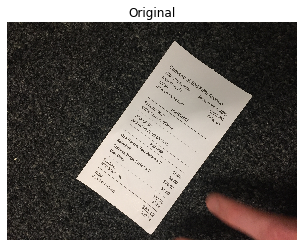

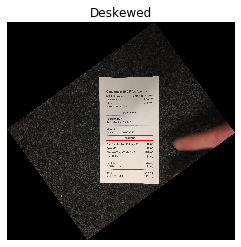

In [225]:
#pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Intern03\AppData\Local\Tesseract-OCR\tesseract.exe'

wd = os.getcwd()
imgs_dir = os.path.join(wd, 'My_Receipts/Original/')
imgs = os.listdir(imgs_dir)
n = random.randint(0,len(imgs)-1)
img = os.path.join(imgs_dir, imgs[n])
print('Receipt: {}\n'.format(imgs[n]))
original = image.imread(img)
plt.figure(),plt.imshow(original),plt.title('Original'),plt.axis('off')

start = time.time()
result = deskew(img)

#oriented = orient_clean2(result)
print('Time: {}s'.format(time.time() - start))

plt.figure(),plt.imshow(result[0]),plt.title('Deskewed'),plt.axis('off')
#plt.figure(),plt.imshow(oriented),plt.title('Final'),plt.axis('off')
plt.show()

<h3> Deskew All Images in Directory; Write Output to New Directory

In [6]:
imgs_dir = os.path.join(wd, 'My_Receipts/Original/')
deskew_dir = os.path.join(wd, 'My_Receipts/Deskewed/')

imgs = os.listdir(imgs_dir)
results_list = []
i = 0

for img in imgs:
    i += 1
    if i%100==0:
        print(i)
    img_path = os.path.join(imgs_dir, img)
    write_path = os.path.join(deskew_dir, img)
    start = time.time()
    result = deskew(img_path)
    runtime = time.time() - start
    results_list.append([img, result[1], runtime])
    try:
        deskewed_img = cv2.cvtColor(result[0], cv2.COLOR_BGR2RGB)
    except:
        print(img)
    cv2.imwrite(write_path, deskewed_img)
    
print('\n\n')
print(len(os.listdir(deskew_dir)))
df = pd.DataFrame(results_list, columns=['img','clockwise_rotation', 'runtime'])
df.to_csv('Deskew_MyReceipts_results.csv')

35
0
[4.0513986749575315, 5.008814099278332, 5.933594767401653, 5.995953040642524, 6.002333571416259, 6.004587373442741, 6.004822867809829, 6.004822867809829, 6.009005957494525, 6.013695413983734]
0.624627668472814
0
[-23.005784355794777, -23.004430958363397, -23.004368276178358, -23.000727236767542, -23.000727236767542, -22.99081878239788, -22.98391594914344, -22.97789675068344, -22.97598400262703, -22.008741951915926, -22.008352167662398, -22.001101203622067, -22.000030528645258, -22.000030528645258, -21.984998009452084, -21.037511025421818, -21.037511025421818, -20.997506459514252]
0.7354241763963465
0
[5.999507320394363, 5.999507320394363, 6.990229427548188, 7.001267557495338, 7.043947029796928, 7.0689539602247935, 7.0689539602247935, 7.912151234530292, 7.989326766396897, 7.989326766396897, 8.0093037764653, 8.014560943306163]
0.7104542212379564
0
[21.037511025421818, 22.01529260610342, 22.970041516068893, 22.970041516068893, 22.975379450961903, 22.98028413167084, 22.98028413167084,

In [54]:
df = pd.DataFrame(results_list, columns=['img','clockwise_rotation', 'runtime'])
df.to_csv('Deskew_5000_results.csv')

(<Figure size 432x288 with 1 Axes>,
 Text(0.5, 1.0, 'Original'),
 (-0.5, 3263.5, 2447.5, -0.5))

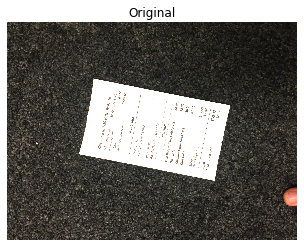

In [33]:
def contrast_bump(img_file):
    img = image.imread(img_file)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.convertScaleAbs(img, alpha = 1.5)
    return img

plt.figure(),plt.imshow(contrast_bump(img)),plt.title('Original'),plt.axis('off')

